# Proyek Klasifikasi Gambar: Animals
- **Nama:** Khansa Maritza Ar-Rahmah
- **Email:** khansamaritzaar@gmail.com
- **ID Dicoding:** khansartz

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import os
import random
from random import sample
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import shutil

# Image processing
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from skimage.transform import resize
from skimage.util import random_noise
from skimage.exposure import adjust_gamma

# Deep learning
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import (
    InputLayer, Conv2D, SeparableConv2D,
    MaxPooling2D, MaxPool2D, Dense, Flatten,
    Dropout, BatchNormalization
)
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import tensorflow.keras.preprocessing.image as keras_image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import tensorflowjs as tfjs
from tensorflow.keras.models import load_model

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Warning
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khansartz","key":"45499645474f1473e896fe62629d1776"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d alessiocorrado99/animals10
!unzip animals10.zip

Streaming output truncated to the last 5000 lines.
  inflating: raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: raw-img/ragno/OIP-Mis0lJf3

### Data Preprocessing

#### Split Dataset

In [7]:
dataset_path = "raw-img/"
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "scoiattolo": "squirrel", "ragno": "spider"
}

# Rename semua folder
for old_name in os.listdir(dataset_path):
    if old_name in translate:
        new_name = translate[old_name]
        os.rename(os.path.join(dataset_path, old_name), os.path.join(dataset_path, new_name))
        print(f"Renamed {old_name} ➡️ {new_name}")

Renamed mucca ➡️ cow
Renamed pecora ➡️ sheep
Renamed ragno ➡️ spider
Renamed cane ➡️ dog
Renamed gallina ➡️ chicken
Renamed scoiattolo ➡️ squirrel
Renamed farfalla ➡️ butterfly
Renamed cavallo ➡️ horse
Renamed elefante ➡️ elephant
Renamed gatto ➡️ cat


Jumlah Gambar per Kelas:
- dog: 4863 gambar
- chicken: 3098 gambar
- spider: 4821 gambar

Total Semua Kelas: 12782 gambar

Ukuran rata-rata gambar (dari 1 contoh per kelas): 300x203


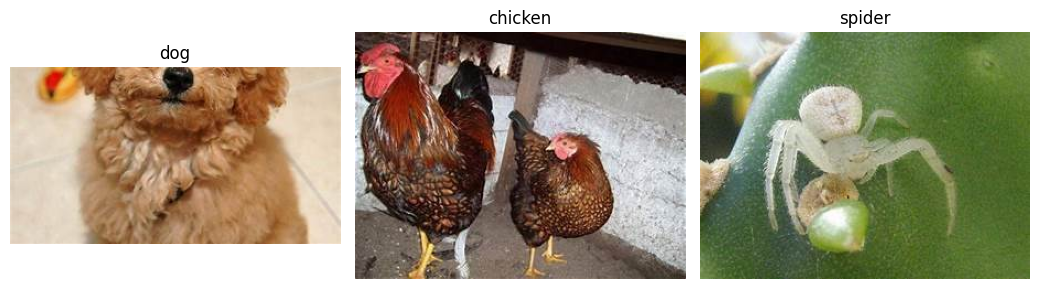

In [8]:
# Path ke folder dataset
dataset_path = "raw-img/"

# Kelas yang akan digunakan
selected_classes = ['dog', 'chicken', 'spider']

image_counts = {}
image_shapes = []
example_images = {}

# Loop per kelas
for cls in selected_classes:
    class_path = os.path.join(dataset_path, cls)
    image_list = os.listdir(class_path)

    # Simpan jumlah gambar per kelas
    image_counts[cls] = len(image_list)

    # Ambil 1 gambar contoh untuk disimpan
    sample_path = os.path.join(class_path, image_list[0])
    img = Image.open(sample_path)
    example_images[cls] = img
    image_shapes.append(img.size)

# Print jumlah gambar per kelas dan total
print("Jumlah Gambar per Kelas:")
total_images = 0

for cls, count in image_counts.items():
    print(f"- {cls}: {count} gambar")
    total_images += count

# Print total gambar
print(f"\nTotal Semua Kelas: {total_images} gambar")

# Cek dimensi rata-rata
widths, heights = zip(*image_shapes)
avg_width = sum(widths) // len(widths)
avg_height = sum(heights) // len(heights)
print(f"\nUkuran rata-rata gambar (dari 1 contoh per kelas): {avg_width}x{avg_height}")

# Menampilkan contoh gambar dari tiap kelas
plt.figure(figsize=(len(selected_classes) * 3.5, 5))
for i, cls in enumerate(selected_classes):
    plt.subplot(1, len(selected_classes), i + 1)
    plt.imshow(example_images[cls])
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

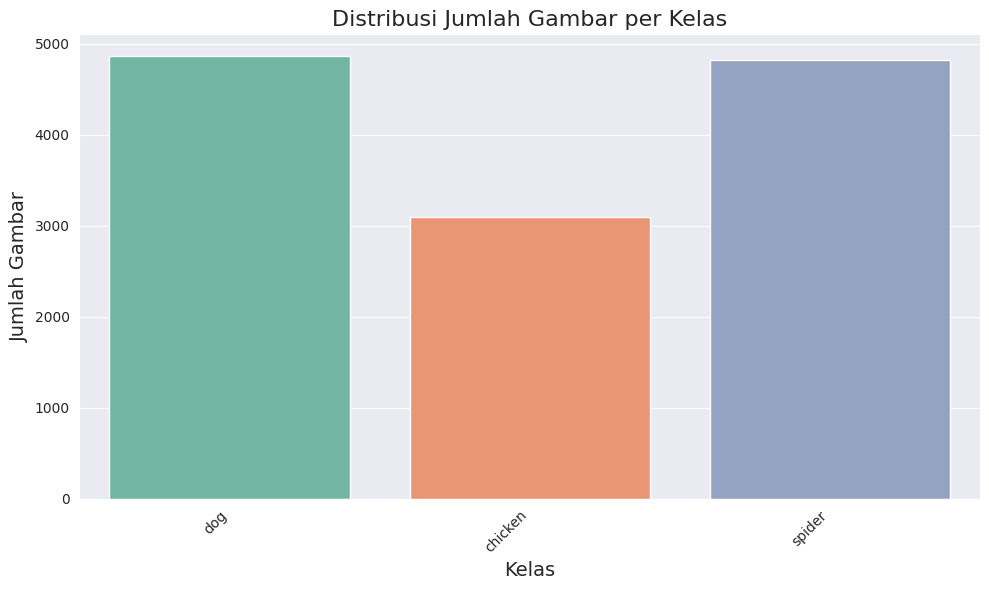

In [9]:
image_paths = []
labels = []

# Iterasi untuk setiap kelas yang dipilih
for cls in selected_classes:
    class_path = os.path.join(dataset_path, cls)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image_paths.append(image_path)
        labels.append(cls)

# Membuat DataFrame
distribution_train = pd.DataFrame({'image_paths': image_paths, 'labels': labels})

# Plot distribusi gambar per kelas
Label = distribution_train['labels']
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x=Label, palette="Set2")

# Judul dan label
plt.title("Distribusi Jumlah Gambar per Kelas", fontsize=16)
plt.xlabel("Kelas", fontsize=14)
plt.ylabel("Jumlah Gambar", fontsize=14)

plt.xticks(rotation=45, ha="right")

# Tampilkan plot
plt.tight_layout()
plt.show()

In [10]:
image_paths = []
labels = []

for cls in selected_classes:
    class_path = os.path.join(dataset_path, cls)
    for image in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, image))
        labels.append(cls)

# Buat DataFrame
df = pd.DataFrame({'path': image_paths, 'labels': labels})

# Split ke train/val/test (70/15/15)
X_temp, X_test, y_temp, y_test = train_test_split(
    df['path'], df['labels'], test_size=0.15, stratify=df['labels'], random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
)

# Gabungkan jadi satu DataFrame final
df_train = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'val'})
df_test = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Cek distribusi per set per kelas
print("Distribusi data:")
print(df_all.groupby(['set', 'labels']).size())

# Path buat dataset hasil split
output_path = "Dataset-Split"

# Salin file ke folder tujuan
for _, row in tq(df_all.iterrows(), total=len(df_all)):
    dest_dir = os.path.join(output_path, row['set'], row['labels'])
    os.makedirs(dest_dir, exist_ok=True)
    shutil.copy2(row['path'], os.path.join(dest_dir, os.path.basename(row['path'])))

Distribusi data:
set    labels 
test   chicken     465
       dog         730
       spider      723
train  chicken    2168
       dog        3403
       spider     3375
val    chicken     465
       dog         730
       spider      723
dtype: int64


  0%|          | 0/12782 [00:00<?, ?it/s]

In [11]:
TRAIN_DIR = "Dataset-Split/train/"
TEST_DIR = "Dataset-Split/test/"
VAL_DIR = "Dataset-Split/val/"

train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

Found 1918 images belonging to 3 classes.
Found 8946 images belonging to 3 classes.
Found 1918 images belonging to 3 classes.


## Modelling

In [13]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,899 (1.74 MB)

 Trainable params: 455,939 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [14]:
# Callbacks
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 158s 505ms/step - accuracy: 0.5607 - loss: 1.0055 - val_accuracy: 0.3734 - val_loss: 1.8105 - learning_rate: 5.0000e-04
Epoch 2/20
  1/279 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.6875 - loss: 0.8557

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


279/279 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.6875 - loss: 0.8557 - val_accuracy: 0.3787 - val_loss: 1.7302 - learning_rate: 5.0000e-04
Epoch 3/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 142s 508ms/step - accuracy: 0.7209 - loss: 0.6642 - val_accuracy: 0.6446 - val_loss: 0.7769 - learning_rate: 5.0000e-04
Epoch 4/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8125 - loss: 0.5022 - val_accuracy: 0.6451 - val_loss: 0.7858 - learning_rate: 5.0000e-04
Epoch 5/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 123s 442ms/step - accuracy: 0.7926 - loss: 0.5268 - val_accuracy: 0.8162 - val_loss: 0.4543 - learning_rate: 5.0000e-04
Epoch 6/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9375 - loss: 0.2450 - val_accuracy: 0.8109 - val_loss: 0.4582 - learning_rate: 5.0000e-04
Epoch 7/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 202s 670ms/step - accuracy: 0.8277 - loss: 0.4467 - val_accuracy: 0.7929 - val_loss: 0.5527 - learning_rate: 5.0000e-04
Epoch 8/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accur

## Evaluasi dan Visualisasi

In [15]:
# Evaluasi model
evaluation = model.evaluate(
    test_generator,
    steps=len(test_generator),
    verbose=1
)

# Output hasil
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.8588 - loss: 0.3917
Test Loss: 0.3074059784412384
Test Accuracy: 0.8894681930541992


In [16]:
# Evaluasi Train, Validation, dan Test Set
train_loss, train_acc = model.evaluate(train_generator, verbose=1)
val_loss, val_acc = model.evaluate(validation_generator, verbose=1)
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

# Output Akurasi
print(f"Akurasi Train Set: {train_acc*100:.2f}%")
print(f"Akurasi Validation Set: {val_acc*100:.2f}%")
print(f"Akurasi Test Set: {test_acc*100:.2f}%")

280/280 ━━━━━━━━━━━━━━━━━━━━ 113s 403ms/step - accuracy: 0.9127 - loss: 0.2522
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8656 - loss: 0.3609
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.8588 - loss: 0.3917
Akurasi Train Set: 91.18%
Akurasi Validation Set: 88.79%
Akurasi Test Set: 88.95%


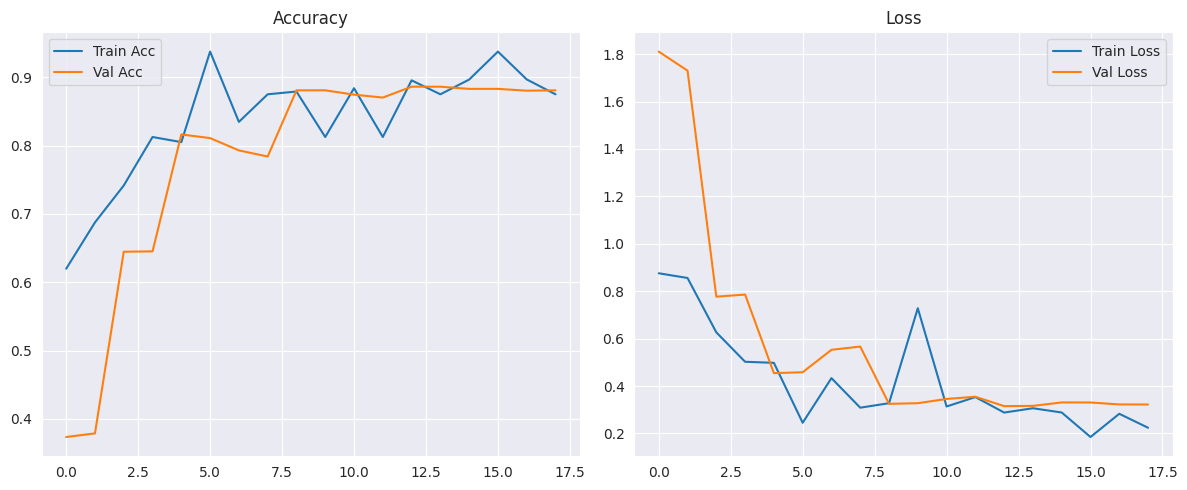

In [17]:
#Visualisasi
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step


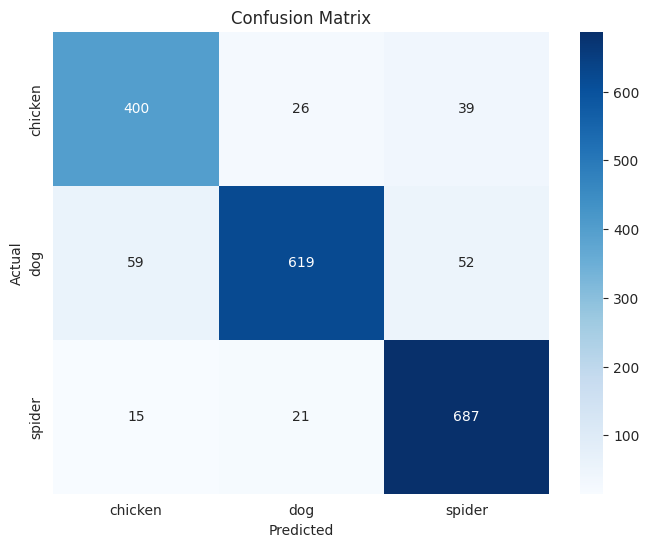

              precision    recall  f1-score   support

     chicken     0.8439    0.8602    0.8520       465
         dog     0.9294    0.8479    0.8868       730
      spider     0.8830    0.9502    0.9154       723

    accuracy                         0.8895      1918
   macro avg     0.8854    0.8861    0.8847      1918
weighted avg     0.8912    0.8895    0.8891      1918



In [18]:
# Reset generator untuk memastikan urutan hasil prediksi
test_generator.reset()

# Prediksi
preds = model.predict(test_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

## Konversi Model

In [19]:
# SavedModel
tf.saved_model.save(model, 'saved_model')

# TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpen model.tflite ke folder tflite/
os.makedirs('tflite', exist_ok=True)
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Simpen label.txt
class_names = ['dog', 'chicken', 'spider']
with open('tflite/label.txt', 'w') as f:
    for label in class_names:
        f.write(label + '\n')

# TensorFlow.js
tfjs.converters.save_keras_model(model, 'tfjs_model')

Saved artifact at '/tmp/tmprnq3559f'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_17')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139732065303632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732065304400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732063601680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732063601104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732065302864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732063601296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732063603216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732063603792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732063603984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732063602832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13973206360

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

Pilih kelas gambar yang mau diuji:
1. chicken
2. dog
3. spider
Pilih angka (1/2/3): 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


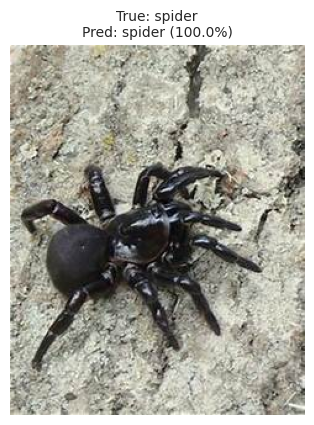

In [25]:
# Load model
model = load_model('best_model.keras')

# Nama kelas
class_names = ['chicken', 'dog', 'spider']
test_dir = 'Dataset-Split/test'

# Fungsi prediksi
def classify_image(img_path, model, img_size=(128, 128)):
    img = keras_image.load_img(img_path, target_size=img_size)
    img_arr = keras_image.img_to_array(img)
    img_arr = np.expand_dims(img_arr / 255.0, axis=0)

    probs = model.predict(img_arr)[0]
    predicted_idx = np.argmax(probs)
    predicted_label = class_names[predicted_idx]
    confidence = probs[predicted_idx]

    return predicted_label, confidence

# User pilih kelas
print("Pilih kelas gambar yang mau diuji:")
for idx, cls in enumerate(class_names):
    print(f"{idx+1}. {cls}")

selected_idx = int(input("Pilih angka (1/2/3): ")) - 1
selected_class = class_names[selected_idx]

# Ambil satu gambar dari kelas yang dipilih
cls_folder = os.path.join(test_dir, selected_class)
images = [img for img in os.listdir(cls_folder) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

if images:
    chosen_img = os.path.join(cls_folder, images[0])
    predicted_label, conf = classify_image(chosen_img, model)

    # Tampil gambar
    img_display = Image.open(chosen_img)
    plt.imshow(img_display)
    plt.axis('off')
    plt.title(f"True: {selected_class}\nPred: {predicted_label} ({conf:.1%})", fontsize=10)
    plt.show()
else:
    print(f"Gambar di kelas '{selected_class}' tidak ada.")
